### Experimenting with Python EEG Packages  
  
These packages include MNE, EEGLIB, NeuroDSP, and FOOOF. If I find others, I'll test them out here, as well.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet, pyarrow
import mne

In [2]:
df = pd.read_csv('metadata_80.csv')

In [3]:
df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,row
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,1
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0,2
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0,3
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80327,4293144208,1,6.0,1224582295,2,240.0,1525390297,64445,Other,0,0,0,0,0,3,49063
80328,4293306306,0,0.0,819682076,3,168.0,1974235411,37409,GPD,0,1,6,0,2,6,34340
80329,4293354003,0,0.0,1188113564,0,0.0,447244163,16610,GRDA,0,0,0,0,1,1,47742
80330,4293843368,0,0.0,1549502620,0,0.0,1618953053,15065,GRDA,0,0,0,0,1,1,61285


In [4]:
patient_list = np.unique(df['patient_id'])

In [5]:
def within_eeg(data, eeg_id):
    subset = data[data['eeg_id'] == eeg_id].copy()
    subset = subset.reset_index().drop(columns = 'index')
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(eeg_id), engine = 'pyarrow')
    full = eeg[0:10000].copy()
    for i in range(1, subset.shape[0]):
        start = int(subset['eeg_label_offset_seconds'][i] * 200)
        stop = start + 10000
        sub_eeg = eeg[start:stop].copy()
        full = pd.concat([full, sub_eeg])
    return full.reset_index().drop(columns = 'index')

def within_patient(data, patient):
    patient_data = data[data['patient_id'] == patient].copy()
    patient_data = patient_data.reset_index().drop(columns = 'index')
    unique_eegs = np.unique(patient_data['eeg_id'])
    full = within_eeg(patient_data, unique_eegs[0])
    for i in range(1, len(unique_eegs)):
        eeg = within_eeg(patient_data, unique_eegs[i])
        full = pd.concat([full, eeg])
    return full.reset_index().drop(columns = 'index')

In [6]:
patient1 = within_patient(df, patient_list[0])

In [7]:
info = mne.create_info(
    patient1.columns.to_list(),
    ch_types=(["eeg"]*(len(patient1.columns)-1))+['ecg'],
    sfreq=200
)
info.set_montage("standard_1020")

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,22 points
Good channels,"19 EEG, 1 ECG"
Bad channels,None
EOG channels,Not available
ECG channels,EKG
Sampling frequency,200.00 Hz
Highpass,0.00 Hz
Lowpass,100.00 Hz


In [8]:
raw = mne.io.RawArray(
    patient1.to_numpy().T*1e-6,    # µV to V
    info
)

Creating RawArray with float64 data, n_channels=20, n_times=520000
    Range : 0 ... 519999 =      0.000 ...  2599.995 secs
Ready.


Using matplotlib as 2D backend.


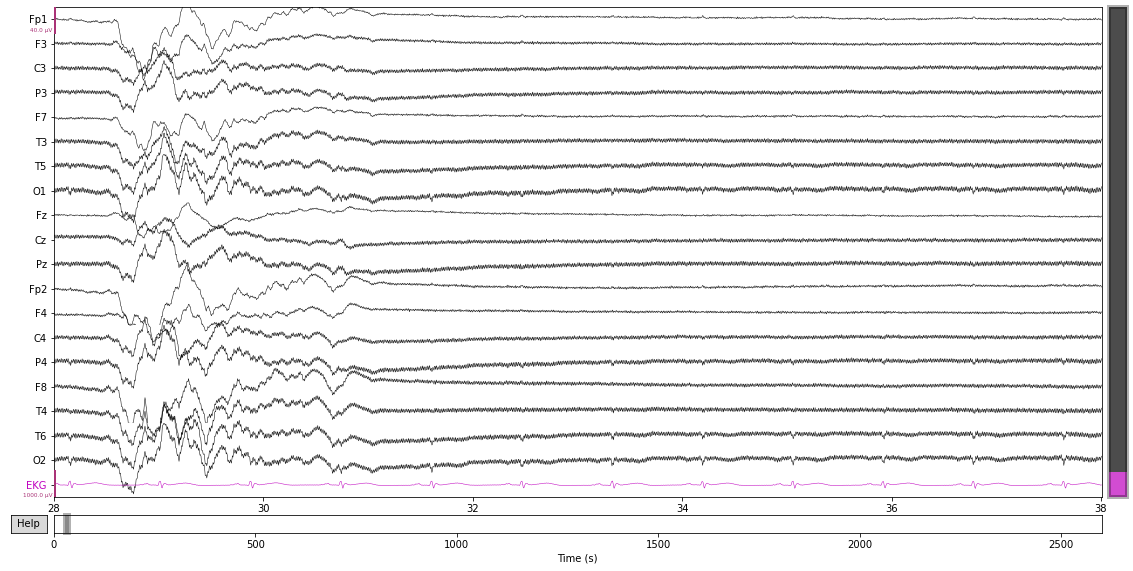

In [9]:
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
raw.plot(start=28, duration=10)
plt.show()

I should have known this already because the code used to load in the data tranposes the array, but MNE arrays of these 20 column EEGs have 20 rows and thousands of columns because they're transposed. This needs to be remembered when writing code to work with the MNE data

In [10]:
raw.get_data().shape

(20, 520000)

Effective window size : 10.240 (s)


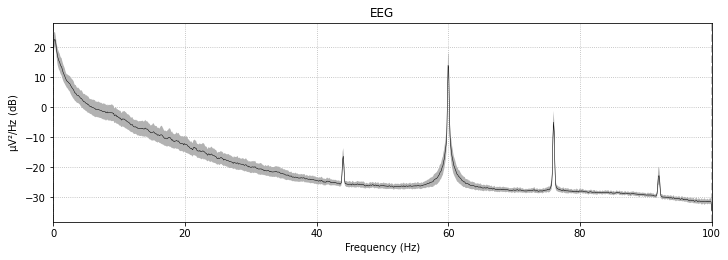

In [11]:
fig = raw.compute_psd(tmax = np.inf).plot(
    average = True, amplitude = False, picks = 'eeg', exclude = 'bads'
)

In [12]:
from mne.decoding import Scaler
from mne.time_frequency import psd_array_welch

In [13]:
scaler = Scaler(scalings = 'mean')
scaler.fit_transform(raw.get_data())

array([[[-1.25677342],
        [-1.42751262],
        [-1.09003616],
        ...,
        [-0.51349367],
        [-0.59711817],
        [-0.52392831]],

       [[-2.08597253],
        [-2.10188695],
        [-2.08746799],
        ...,
        [-0.66911672],
        [-0.67660785],
        [-0.68588742]],

       [[ 0.43297792],
        [ 0.45786292],
        [ 0.41750703],
        ...,
        [-0.14135762],
        [-0.15978794],
        [-0.17772704]],

       ...,

       [[-1.05864633],
        [-0.99533865],
        [-1.12355203],
        ...,
        [-0.44136891],
        [-0.4337532 ],
        [-0.48004171]],

       [[ 0.72449843],
        [ 0.78754252],
        [ 0.77813761],
        ...,
        [-0.11320122],
        [-0.1141499 ],
        [-0.15761802]],

       [[ 0.93129785],
        [ 0.96380685],
        [ 0.47783555],
        ...,
        [ 0.25727042],
        [ 0.74461266],
        [ 0.94484549]]])

Effective window size : 10.240 (s)


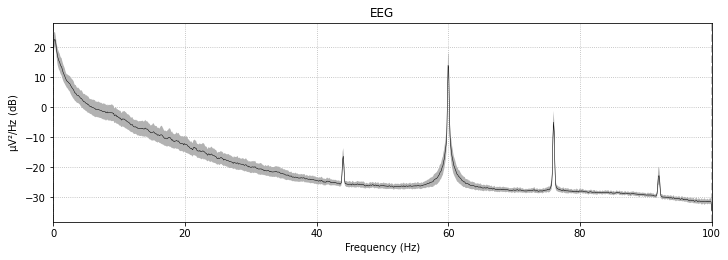

In [14]:
fig = raw.compute_psd(tmax = np.inf).plot(
    average = True, amplitude = False, picks = 'eeg', exclude = 'bads'
)

Effective window size : 10.240 (s)


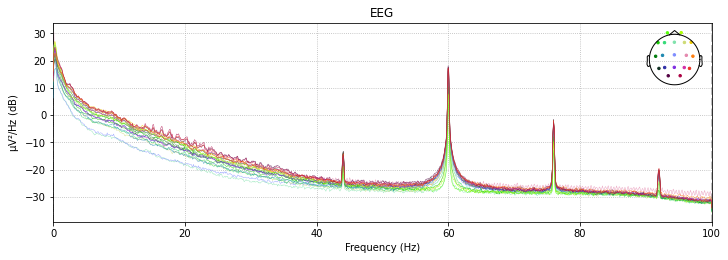

In [15]:
fig = raw.compute_psd(tmax = np.inf).plot(
    average = False, amplitude = False, picks = 'eeg', exclude = 'bads'
)

In [16]:
raw_psd = raw.compute_psd(tmax = np.inf).get_data()
raw_freqs = raw.compute_psd(tmax = np.inf).freqs

Effective window size : 10.240 (s)
Effective window size : 10.240 (s)


In [17]:
raw_psd_welch = psd_array_welch(raw.get_data(), sfreq = 200)

Effective window size : 1.280 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [33]:
help(mne.io.RawArray.compute_psd)

Help on function compute_psd in module mne.io.base:

compute_psd(self, method='welch', fmin=0, fmax=inf, tmin=None, tmax=None, picks=None, exclude=(), proj=False, remove_dc=True, reject_by_annotation=True, *, n_jobs=1, verbose=None, **method_kw)
    Perform spectral analysis on sensor data.
    
    Parameters
    ----------
    
    method : ``'welch'`` | ``'multitaper'``
        Spectral estimation method. ``'welch'`` uses Welch's
        method :footcite:p:`Welch1967`, ``'multitaper'`` uses DPSS
        tapers :footcite:p:`Slepian1978`.
        Default is ``'welch'``.
    fmin, fmax : float
        The lower- and upper-bound on frequencies of interest. Default is ``fmin=0, fmax=np.inf`` (spans all frequencies present in the data).
    tmin, tmax : float | None
        First and last times to include, in seconds. ``None`` uses the first or
        last time present in the data. Default is ``tmin=None, tmax=None`` (all
        times).
    picks : str | array-like | slice | None
      

In [34]:
help(mne.time_frequency.psd_array_welch)

Help on function psd_array_welch in module mne.time_frequency.psd:

psd_array_welch(x, sfreq, fmin=0, fmax=inf, n_fft=256, n_overlap=0, n_per_seg=None, n_jobs=None, average='mean', window='hamming', remove_dc=True, *, output='power', verbose=None)
    Compute power spectral density (PSD) using Welch's method.
    
    Welch's method is described in :footcite:t:`Welch1967`.
    
    Parameters
    ----------
    x : array, shape=(..., n_times)
        The data to compute PSD from.
    sfreq : float
        The sampling frequency.
    fmin : float
        The lower frequency of interest.
    fmax : float
        The upper frequency of interest.
    n_fft : int
        The length of FFT used, must be ``>= n_per_seg`` (default: 256).
        The segments will be zero-padded if ``n_fft > n_per_seg``.
    n_overlap : int
        The number of points of overlap between segments. Will be adjusted
        to be <= n_per_seg. The default value is 0.
    n_per_seg : int | None
        Length of e

The discrepancy between the number of rows makes sense. With compute_psd, setting picks to eeg ensures that the function reads in the eeg channels and no other channels. With psd_array_welch, this isn't done and that means the ekg channel is included as well.  
  
The discrepancy between the number of columns, however, I don't understand. Why does compute_psd generate more than 1000 columns of data and psd_array_welch only generates 129? What is the difference between the two functions? Which should I be using?

In [18]:
raw_psd_welch[0].shape, raw_psd.shape

((20, 129), (19, 1025))

After determining which psd function to use, the next question is how to generate band power features from this data. This can definitely be done manually and I've found some other python packages that seem to do this as well, but does MNE have a function that will return these values? If so, I can use that to generate my feature data and then I just need to generate a feature set large enough that is equally representative of each type of brain activity. That feature set will then need to be scaled and used in base models.

So based on the discussion at the link below, it seems that after calculating the power spectral density across all frequencies in the frequency analysis, the next step is to manually determine what falls within each specific frequency band. In other words, it seems as though there isn't an MNE function which will just do this for you.  
  
https://mne.discourse.group/t/band-power-continuous-data/3426  
  
That's fine, of course. I think it should be fairly easy to take the psd and determine the power of each of the 5 frequency bands.

In [19]:
raw_psd.shape, raw_freqs.shape

((19, 1025), (1025,))

In [20]:
min(raw_freqs)

0.0

In [21]:
from mne_features.univariate import compute_samp_entropy

In [23]:
patient1_eeg1 = raw.get_data(picks = ['eeg'], stop = 10000)

In [24]:
entropy1 = compute_samp_entropy(patient1_eeg1)

In [25]:
entropy1

array([0.17802029, 0.72060059, 0.71234084, 0.96074529, 0.58194051,
       0.59013189, 0.72718529, 0.75439717, 0.59543742, 0.96653196,
       0.69416104, 0.40821373, 0.78887447, 0.69047901, 0.71479381,
       0.59024431, 0.64545215, 0.72669597, 0.73933301])

In [26]:
electrodes = pd.read_parquet('train_eegs/{}.parquet'.format(df['eeg_id'][0]), engine = 'pyarrow').drop(columns = 'EKG').columns

In [27]:
def activity_df(activity):
    return pd.DataFrame(df[df['expert_consensus'] == activity]).reset_index().drop(columns = 'index')

other_df = activity_df('Other')
seizure_df = activity_df('Seizure')
lpd_df = activity_df('LPD')
gpd_df = activity_df('GPD')
lrda_df = activity_df('LRDA')
grda_df = activity_df('GRDA')

In [28]:
def get_sub_eeg(data, row):
    eeg = pd.read_parquet('train_eegs/{}.parquet'.format(data['eeg_id'][row]), engine = 'pyarrow')
    start = int(data['eeg_label_offset_seconds'][row] * 200)
    stop = start + 10000
    sub_eeg = eeg[start:stop]
    return sub_eeg.reset_index().drop(columns = 'index')

In [29]:
def activity_eegs(data, n):
    sub_eeg1 = get_sub_eeg(data, 0)
    for i in range(1, n):
        sub_eeg2 = get_sub_eeg(data, i)
        sub_eeg1 = pd.concat([sub_eeg1, sub_eeg2])
    return sub_eeg1